I. GSEAPY Example
-----------------------------------------------
Examples to use ``GSEApy`` inside python console

In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

**Check gseapy version**

In [2]:
gp.__version__

'1.0.1'

## 1. Biomart API  

Don't use this if you don't know Biomart

Warning: This API has limited support now

### 1.1 convert gene identifiers

In [3]:
from gseapy import Biomart 
bm = Biomart()

In [4]:
## view validated marts
# marts = bm.get_marts()
## view validated dataset
# datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
## view validated attributes
# attrs = bm.get_attributes(dataset='hsapiens_gene_ensembl') 
## view validated filters
# filters = bm.get_filters(dataset='hsapiens_gene_ensembl')
## query results
queries ={'ensembl_gene_id': ['ENSG00000125285','ENSG00000182968'] } # need to be a dict object
results = bm.query(dataset='hsapiens_gene_ensembl', 
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'],
                   filters=queries)
results.head()

,ensembl_gene_id,external_gene_name,entrezgene_id,go_id
0,ENSG00000125285,SOX21,11166,GO:0006355
1,ENSG00000125285,SOX21,11166,GO:0005634
2,ENSG00000125285,SOX21,11166,GO:0003677
3,ENSG00000125285,SOX21,11166,GO:0003700
4,ENSG00000125285,SOX21,11166,GO:0000981


### 1.2  Mouse gene symbols maps to Human, or Vice Versa

This is useful when you have troubles to convert gene symbols between human and mouse

In [5]:
from gseapy import Biomart 
bm = Biomart()
# note the dataset and attribute names are different
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

h2m = bm.query(dataset='hsapiens_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'mmusculus_homolog_ensembl_gene',
                           'mmusculus_homolog_associated_gene_name'])

In [6]:
h2m.sample(10)

,ensembl_gene_id,external_gene_name,mmusculus_homolog_ensembl_gene,mmusculus_homolog_associated_gene_name
23810,ENSG00000274263,MIR7702,NaN,NaN
49556,ENSG00000279391,NaN,NaN,NaN
21335,ENSG00000102910,LONP2,ENSMUSG00000047866,Lonp2
30109,ENSG00000212370,RNU6-482P,NaN,NaN
72993,ENSG00000290594,NaN,NaN,NaN
58569,ENSG00000132744,ACY3,ENSMUSG00000024866,Acy3
25009,ENSG00000276746,Metazoa_SRP,ENSMUSG00000093093,Gm22642
1456,ENSG00000280853,NaN,NaN,NaN
53034,ENSG00000172831,CES2,ENSMUSG00000031877,Ces2g
49806,ENSG00000244482,LILRA6,ENSMUSG00000070873,Lilra5


### 1.3 Gene Symbols Conversion for the GMT file
This is useful when runing GSEA for non-human species

**e.g. Convert Human gene symbols to Mouse.**

In [7]:
# get a dict symbol mappings
h2m_dict = {}
for i, row in h2m.loc[:,["external_gene_name", "mmusculus_homolog_associated_gene_name"]].iterrows():
    if row.isna().any(): continue
    h2m_dict[row['external_gene_name']] = row["mmusculus_homolog_associated_gene_name"]
# read gmt file into dict
kegg = gp.read_gmt(path="tests/extdata/enrichr.KEGG_2016.gmt")
print(kegg['MAPK signaling pathway Homo sapiens hsa04010'][:10])

['EGF', 'IL1R1', 'IL1R2', 'HSPA1L', 'CACNA2D2', 'CACNA2D1', 'CACNA2D4', 'CACNA2D3', 'MAPK8IP3', 'MAPK8IP1']


In [8]:
kegg_mouse = {}
for term, genes in kegg.items():
    new_genes = []
    for gene in genes:
        if gene in h2m_dict:
            new_genes.append(h2m_dict[gene])
    kegg_mouse[term] = new_genes
print(kegg_mouse['MAPK signaling pathway Homo sapiens hsa04010'][:10])

['Egf', 'Il1r1', 'Il1r2', 'Hspa1l', 'Cacna2d2', 'Cacna2d1', 'Cacna2d4', 'Cacna2d3', 'Mapk8ip3', 'Mapk8ip1']


## 2. Enrichr API

**See all supported enrichr library names**  

Select database from **{ 'Human', 'Mouse', 'Yeast', 'Fly', 'Fish', 'Worm' }**

In [9]:
# default: Human
names = gp.get_library_name()
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']

In [10]:
# yeast
yeast = gp.get_library_name(organism='Yeast') 
yeast[:10]

['Cellular_Component_AutoRIF',
 'Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF']

**Parse Enrichr library into dict**

In [11]:
## download library or read a .gmt file
go_mf = gp.get_library(name='GO_Molecular_Function_2018', organism='Yeast')
print(go_mf['ATP binding (GO:0005524)'])

['MLH1', 'ECM10', 'RLI1', 'SSB1', 'SSB2', 'YTA12', 'MSH2', 'CDC6', 'HMI1', 'YNL247W', 'MSH6', 'SSQ1', 'MCM7', 'SRS2', 'HSP104', 'SSA1', 'MCX1', 'SSC1', 'ARP2', 'ARP3', 'SSE1', 'SMC2', 'SSZ1', 'TDA10', 'ORC5', 'VPS4', 'RBK1', 'SSA4', 'NEW1', 'ORC1', 'SSA2', 'KAR2', 'SSA3', 'DYN1', 'PGK1', 'VPS33', 'LHS1', 'CDC123', 'PMS1']


### 2.1  Over-representation analysis by Enrichr web services

The only requirement of input is a list of gene symbols.

For online web services, gene symbols are not case sensitive.


- `gene_list` accepts
    - ``pd.Series``
    -  ``pd.DataFrame`` 
    -  ``list`` object
    - ``txt`` file (one gene symbol per row)


- `gene_sets` accepts:

    Multi-libraries names supported, separate each name by comma or input a list. 

For example:
```python
    # gene_list
    gene_list="./data/gene_list.txt", 
    gene_list=glist
    # gene_sets
    gene_sets='KEGG_2016'  
    gene_sets='KEGG_2016,KEGG_2013'
    gene_sets=['KEGG_2016','KEGG_2013']
```

In [12]:
# read in an example gene list
gene_list = pd.read_csv("./tests/data/gene_list.txt",header=None, sep="\t")
gene_list.head()

,0
0,IGKV4-1
1,CD55
2,IGKC
3,PPFIBP1
4,ABHD4


In [13]:
# convert dataframe or series to list
glist = gene_list.squeeze().str.strip().to_list()
print(glist[:10])

['IGKV4-1', 'CD55', 'IGKC', 'PPFIBP1', 'ABHD4', 'PCSK6', 'PGD', 'ARHGDIB', 'ITGB2', 'CARD6']


### 2.2 Over-representation analysis via Enrichr web services

This is an Example of the Enrichr analysis

**NOTE**: 
1. Enrichr Web Sevices need `gene symbols` as input
2. `Gene symbols` will convert to upcases automatically.

In [14]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list=gene_list, # or "./tests/data/gene_list.txt", 
                 gene_sets=['KEGG_2016','KEGG_2021_Human'], 
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk               
                )

In [15]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Osteoclast differentiation Homo sapiens hsa04380,28/132,3.104504e-13,7.885440e-11,0,0,6.659625,191.802220,LILRA6;ITGB3;LILRA2;LILRA5;PPP3R1;FCGR3B;SIRPA...
1,KEGG_2016,Tuberculosis Homo sapiens hsa05152,31/178,4.288559e-12,5.446470e-10,0,0,5.224941,136.763196,RAB5B;ITGB2;PPP3R1;HLA-DMA;FCGR3B;HLA-DMB;CASP...
2,KEGG_2016,Phagosome Homo sapiens hsa04145,28/154,1.614009e-11,1.366528e-09,0,0,5.490501,136.437381,ATP6V1A;RAB5B;ITGB5;ITGB3;ITGB2;HLA-DMA;FCGR3B...
3,KEGG_2016,Rheumatoid arthritis Homo sapiens hsa05323,19/90,2.197884e-09,1.395656e-07,0,0,6.554453,130.668081,ATP6V1A;ATP6V1G1;ATP6V0B;TGFB1;ITGB2;FOS;ITGAL...
4,KEGG_2016,Leishmaniasis Homo sapiens hsa05140,17/73,3.132614e-09,1.591368e-07,0,0,7.422186,145.336773,TGFB1;IFNGR1;PRKCB;IFNGR2;ITGB2;FOS;MAPK14;HLA...


### 2.3 Over-representation analysis (hypergeometric test) by offline

This API **DO NOT** use Enrichr web services.


**NOTE**:
1. The input gene symbols are **case sensitive**.
2. You need to **match the type of the gene identifers** which used in your gene_list input and GMT file. 
3. Input a .gmt file or gene_set dict object for the argument `gene_sets`

For example:
```python
    gene_sets="./data/genes.gmt",
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```

In [16]:
# NOTE: `enrich` instead of `enrichr`
enr2 = gp.enrich(gene_list="./tests/data/gene_list.txt", # or gene_list=glist
                 gene_sets="./tests/data/genes.gmt",
                 background="hsapiens_gene_ensembl",
                 outdir=None, 
                 verbose=False)

In [17]:
enr2.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM139696779290496,BvA_UpIN_A,8/130,0.029765,0.069452,2.343931,PADI2;IQGAP2;PCSK6;MAP3K5;MBOAT2;MSRB2;HAL;IL1R1
1,CUSTOM139696779290496,BvA_UpIN_B,11/124,0.000729,0.005100,3.339341,KCTD12;HEBP1;DYSF;SYK;LPAR1;MBNL3;IL1RAP;ST3GA...
2,CUSTOM139696779290496,CvA_UpIN_A,1/11,0.267894,0.375052,4.669004,MBOAT2
3,CUSTOM139696779290496,DvA_UpIN_A,16/259,0.002705,0.009466,2.302945,BCL3;ATP6V1B2;PADI2;IQGAP2;PCSK6;PTGS1;IFNGR2;...
4,CUSTOM139696779290496,DvA_UpIN_D,11/218,0.043392,0.075936,1.895541,SIRPA;HEBP1;DYSF;GLIPR2;LPAR1;MBNL3;IL1RAP;ST3...


#### About Background genes 

By default, all genes in the `gene_sets` input will be used as background. 

However, a better background genes would be the following:


1. (Recommended) Input a list of background genes: ['gene1', 'gene2',...]
    - The background gene list is defined by your experment. e.g. the expressed genes in your RNA-seq.
    - The gene identifer in gmt/dict should be the same type to the backgound genes.

2. Specify a number: e.g. 20000. (the number of total expressed genes).
    - This works, but not recommend. It assumes that all your genes could be found in background.
    - If genes exist in gmt but not included in background provided, they will affect the significance of the statistical test.

3. Set a Biomart dataset name: e.g. "hsapiens_gene_ensembl"
    - The background will use all annotated genes from the `BioMart datasets` you've choosen.
    - The program will try to retrieve the background information automatically.


### 2.4 Plotting

Show top 5 terms of each gene_set ranked by "Adjusted P-value"

In [18]:
# simple plotting function
from gseapy import barplot, dotplot

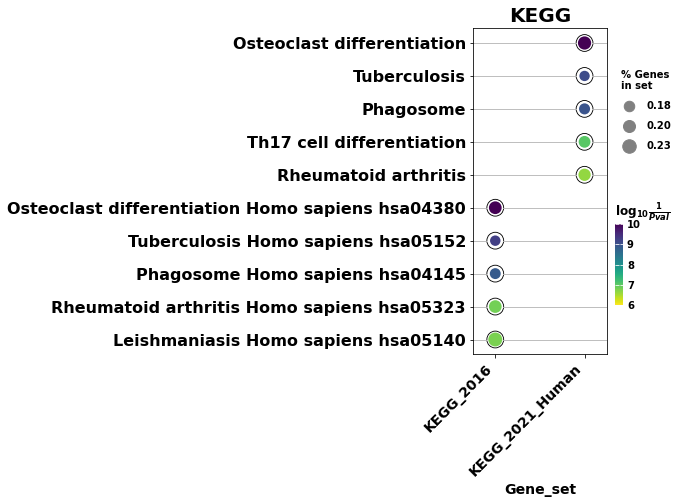

In [19]:
# categorical scatterplot
ax = dotplot(enr.results, 
              column="Adjusted P-value", 
              group='Gene_set', # set x, so you could do a multi-sample/library comparsion
              size=10, 
              top_term=5,
              figsize=(3,6), 
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

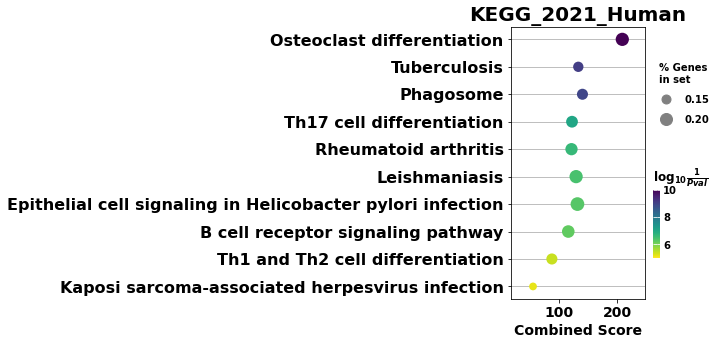

In [20]:
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(enr.res2d, title='KEGG_2021_Human',cmap='viridis_r', size=10, figsize=(3,5))

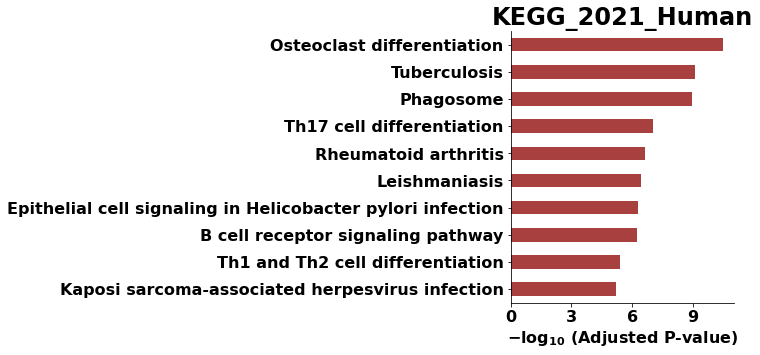

In [21]:
# to save your figure, make sure that ``ofname`` is not None
ax = barplot(enr.res2d,title='KEGG_2021_Human', figsize=(4, 5), color='darkred')

### 2.5 Command line usage 

the option **-v** will print out the progress of your job

In [22]:
# !gseapy enrichr -i ./data/gene_list.txt \
#                 -g GO_Biological_Process_2017 \
#                 -v -o test/enrichr_BP

## 3. Prerank example

### 3.1 Assign prerank() with 

- pd.DataFrame: Only contains two columns, or one cloumn with gene_name indexed 
- pd.Series 
- a txt file: 
  - **GSEApy will skip any data after "#".** 
  - Do not include header in your gene list !  


### NOTE: UPCASES for gene symbols by Default

1. Gene symbols are all "UPCASES" in the Enrichr Libaries. You should convert your input gene identifier to "UPCASES" first.
2. If input `gmt`, `dict` object, please refer to `1.2 Mouse gene symbols maps to Human, or Vice Versa` (in this page) to convert gene identifier



#### Supported gene_sets input
For example:
```python
    gene_sets="KEGG_2016",
    gene_sets="KEGG_2016,KEGG2013",
    gene_sets="./data/genes.gmt",
    gene_sets=["KEGG_2016","./data/genes.gmt"],
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```

In [23]:
rnk = pd.read_csv("./tests/data/temp.rnk", header=None, index_col=0, sep="\t")
rnk.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [24]:
rnk.shape

(22922, 1)

In [25]:
# # run prerank
# # enrichr libraries are supported by prerank module. Just provide the name
# # use 4 process to acceralate the permutation speed
pre_res = gp.prerank(rnk="./tests/data/temp.rnk", # or rnk = rnk,
                     gene_sets='KEGG_2016', 
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk 
                     seed=6, 
                     verbose=True, # see what's going on behind the scenes
                    )

2022-12-06 15:22:51,083 Duplicated values found in preranked stats: 4.97% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
The order of those genes will be arbitrary, which may produce unexpected results.


### 3.2 How to generate your GSEA plot inside python console  
Visualize it using ``gseaplot``  

Make sure that ``ofname`` is not None, if you want to save your figure to the disk

In [26]:
pre_res.res2d.head(5)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Adherens junction Homo sapiens hsa04520,0.784625,1.912548,0.0,0.0,0.0,47/74,10.37%,CTNNB1;EGFR;RAC1;TGFBR1;SMAD4;MET;EP300;CDC42;...
1,prerank,Glioma Homo sapiens hsa05214,0.784678,1.906706,0.0,0.0,0.0,52/65,16.29%,CALM1;GRB2;EGFR;PRKCA;KRAS;HRAS;TP53;MAPK1;PRK...
2,prerank,Estrogen signaling pathway Homo sapiens hsa04915,0.766347,1.897957,0.0,0.0,0.0,74/99,16.57%,CALM1;PRKACA;GRB2;SP1;EGFR;KRAS;HRAS;HSP90AB1;...
3,prerank,Thyroid hormone signaling pathway Homo sapiens...,0.7577,1.891815,0.0,0.0,0.0,84/118,16.29%,CTNNB1;PRKACA;PRKCA;KRAS;NOTCH1;EP300;CREBBP;H...
4,prerank,Long-term potentiation Homo sapiens hsa04720,0.778249,1.888739,0.0,0.0,0.0,42/66,9.01%,CALM1;PRKACA;PRKCA;KRAS;EP300;CREBBP;HRAS;PRKA...


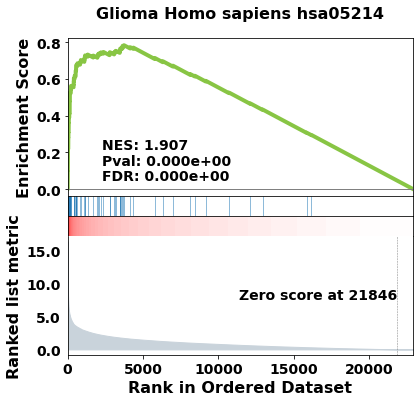

In [27]:
## easy way
from gseapy import gseaplot
terms = pre_res.res2d.Term
i = 1
# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking, 
         term=terms[i], 
         **pre_res.results[terms[i]])

# save figure
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

/home/fangzq/github/GSEApy/gseapy/plot.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.colname].clip(1e-5, 1.0, inplace=True)


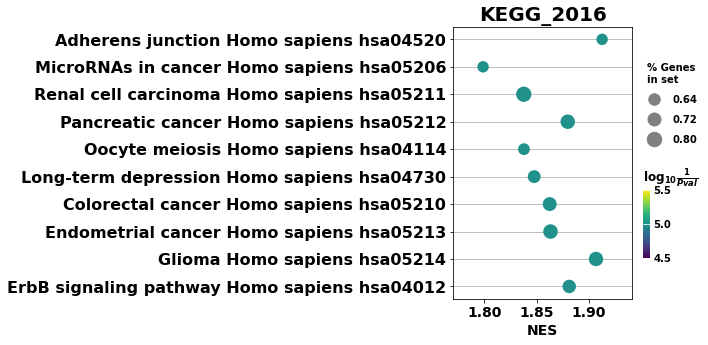

In [28]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(pre_res.res2d, 
             column="FDR q-val",
             title='KEGG_2016',
             cmap=plt.cm.viridis, 
             size=3, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

/home/fangzq/github/GSEApy/gseapy/plot.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.colname].clip(1e-5, 1.0, inplace=True)


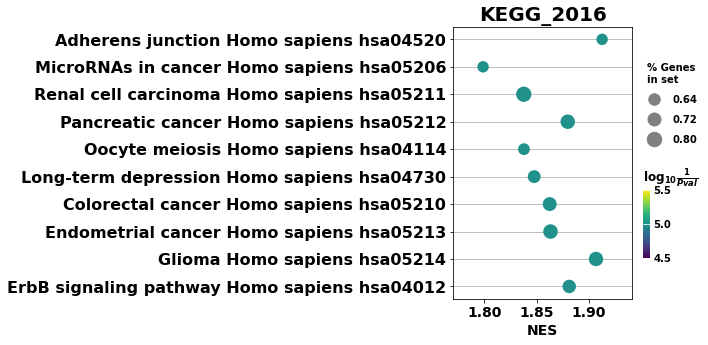

In [29]:
ax = dotplot(pre_res.res2d, 
             column="FDR q-val",
             title='KEGG_2016',
             cmap=plt.cm.viridis, 
             size=3, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

### 3.2 Command line usage 

You may also want to use prerank in command line

In [30]:
# !gseapy prerank -r temp.rnk -g temp.gmt -o prerank_report_temp

## 4. GSEA Example


### 4.1 Inputs 

Assign gsea() 

- data with: 
  - pandas DataFrame
  - .gct format file, or a text file

- cls with: 
  - a list
  - a .cls format file 

- gene_sets with:

```python
    gene_sets="KEGG_2016",
    gene_sets="KEGG_2016,KEGG2013",
    gene_sets="./data/genes.gmt",
    gene_sets=["KEGG_2016","./data/genes.gmt"],
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```


### NOTE: UPCASES for gene symbols by Default

1. Gene symbols are all "UPCASES" in the Enrichr Libaries. You should convert your input gene identifier to "UPCASES" first.
2. If input `gmt`, `dict` object, please refer to `1.2 Mouse gene symbols maps to Human, or Vice Versa` (in this page) to convert gene identifier


In [31]:
phenoA, phenoB, class_vector =  gp.parser.gsea_cls_parser("./tests/extdata/Leukemia.cls")

In [32]:
#class_vector used to indicate group attributes for each sample
print(class_vector)

['ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML']


In [33]:
gene_exp = pd.read_csv("./tests/extdata/Leukemia_hgu95av2.trim.txt", sep="\t")
gene_exp.head()

,Gene,NAME,ALL_1,ALL_2,ALL_3,ALL_4,ALL_5,ALL_6,ALL_7,ALL_8,...,AML_15,AML_16,AML_17,AML_18,AML_19,AML_20,AML_21,AML_22,AML_23,AML_24
0,MAPK3,1000_at,1633.6,2455.0,866.0,1000.0,3159.0,1998.0,1580.0,1955.0,...,1826.0,2849.0,2980.0,1442.0,3672.0,294.0,2188.0,1245.0,1934.0,13154.0
1,TIE1,1001_at,284.4,159.0,173.0,216.0,1187.0,647.0,352.0,1224.0,...,1556.0,893.0,1278.0,301.0,797.0,248.0,167.0,941.0,1398.0,-502.0
2,CYP2C19,1002_f_at,285.8,114.0,429.0,-43.0,18.0,366.0,119.0,-88.0,...,-177.0,64.0,-359.0,68.0,2.0,-464.0,-127.0,-279.0,301.0,509.0
3,CXCR5,1003_s_at,-126.6,-388.0,143.0,-915.0,-439.0,-371.0,-448.0,-862.0,...,237.0,-834.0,-1940.0,-684.0,-1236.0,-1561.0,-895.0,-1016.0,-2238.0,-1362.0
4,CXCR5,1004_at,-83.3,33.0,195.0,85.0,54.0,-6.0,55.0,101.0,...,86.0,-5.0,487.0,102.0,33.0,-153.0,-50.0,257.0,439.0,386.0


In [34]:
print("positively correlated: ", phenoA)

positively correlated:  ALL


In [35]:
print("negtively correlated: ", phenoB)

negtively correlated:  AML


In [36]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name
gs_res = gp.gsea(data=gene_exp, # or data='./P53_resampling_data.txt'
                 gene_sets='./tests/extdata/h.all.v7.0.symbols.gmt', # or enrichr library names
                 cls= "./tests/extdata/Leukemia.cls", # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype', 
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 7)

2022-12-06 15:23:05,889 Warning: dropping duplicated gene names, only keep the first values


In [37]:
#access the dataframe results throught res2d attribute
gs_res.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,HALLMARK_E2F_TARGETS,0.574187,1.661335,0.052521,0.577605,0.259,87/151,23.65%,DCK;BARD1;NASP;SRSF2;STMN1;SRSF1;TRA2B;EZH2;SM...
1,gsea,HALLMARK_MITOTIC_SPINDLE,0.430183,1.646924,0.026804,0.31929,0.279,84/147,37.31%,SPTAN1;SEPT9;ATG4B;SMC1A;MYH10;BIN1;CYTH2;TUBG...
2,gsea,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.438876,1.586567,0.013834,0.293792,0.353,11/30,22.99%,LEF1;SKP2;HDAC2;GNAI1;CUL1;MAML1;WNT1;HDAC5;AX...
3,gsea,HALLMARK_TNFA_SIGNALING_VIA_NFKB,-0.49294,-1.521229,0.111562,1.0,0.466934,104/177,28.92%,MCL1;CEBPB;PLAU;IL18;PLEK;BCL3;CEBPD;PLAUR;JUN...
4,gsea,HALLMARK_MYC_TARGETS_V1,0.535105,1.519305,0.156448,0.341741,0.481,115/174,33.61%,HNRNPA3;HDDC2;RFC4;SRSF2;SRSF1;TRA2B;RRM1;HNRN...


### 4.2 Show the gsea plots

The **gsea** module will generate heatmap for genes in each gene sets in the backgroud.  
But if you need to do it yourself, use the code below

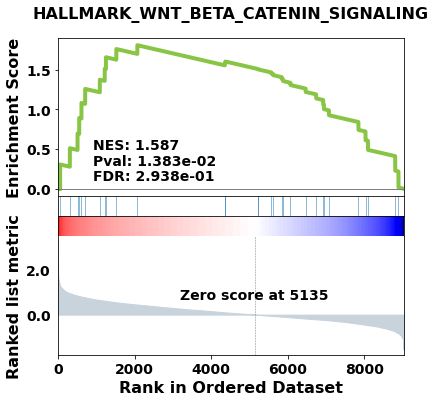

In [38]:
from gseapy import gseaplot, heatmap
terms = gs_res.res2d.Term
i = 2
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(gs_res.ranking, term=terms[i], **gs_res.results[terms[i]])

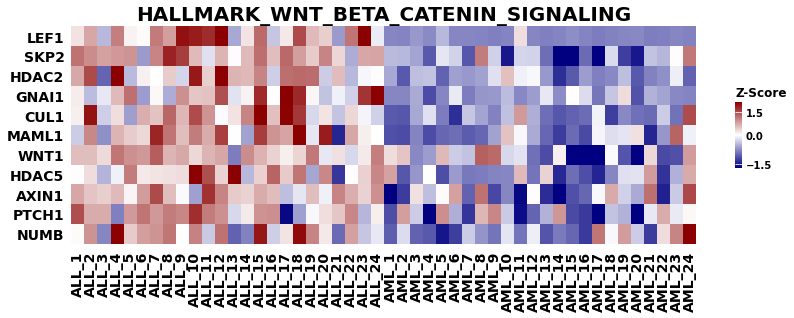

In [39]:
# plotting heatmap
genes = gs_res.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
ax = heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4))

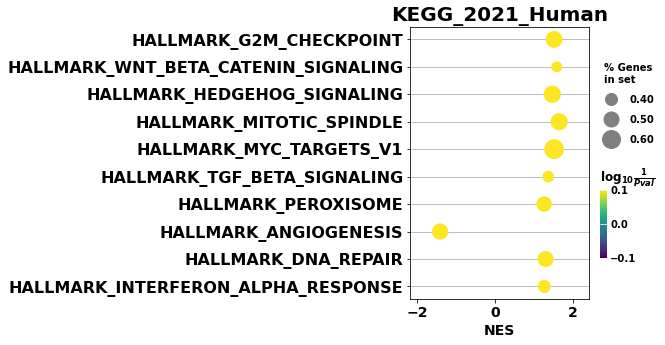

In [40]:
from gseapy import dotplot, ringplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(gs_res.res2d, 
             column="FDR q-val",
             title='KEGG_2021_Human',
             cmap=plt.cm.viridis, 
             size=5, 
             figsize=(4,5), cutoff=1)

### 4.3 Command line usage 

You may also want to use gsea in command line

In [41]:
# !gseapy gsea -d ./data/P53_resampling_data.txt \
#              -g KEGG_2016 -c ./data/P53.cls \
#              -o test/gsea_reprot_2 \
#              -v --no-plot \
#              -t phenotype

## 5. Single Sample GSEA example

**Note: When you run ssGSEA, all genes names in your gene_sets file should be found in your expression table**

What's ssGSEA? Which one should I use? Prerank or ssGSEA

see FAQ [here](https://github.com/zqfang/GSEApy/wiki/FAQ)


### 5.1 Input format  
Assign 
- `data` with 
  - a txt file, gct file, 
  - pd.DataFrame
  - pd.Seires(gene name as index)
  
- gene_sets with:

```python
    gene_sets="KEGG_2016",
    gene_sets="KEGG_2016,KEGG2013",
    gene_sets="./data/genes.gmt",
    gene_sets=["KEGG_2016","./data/genes.gmt"],
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```


### NOTE: UPCASES for gene symbols by Default

1. Gene symbols are all "UPCASES" in the Enrichr Libaries. You should convert your input gene identifier to "UPCASES" first.
2. If input `gmt`, `dict` object, please refer to `1.2 Mouse gene symbols maps to Human, or Vice Versa` (in this page) to convert gene identifier


In [42]:
import gseapy as gp
# txt, gct file input
ss = gp.ssgsea(data='./tests/extdata/Leukemia_hgu95av2.trim.txt',
               gene_sets='./tests/extdata/h.all.v7.0.symbols.gmt',
               outdir=None, 
               sample_norm_method='rank', # choose 'custom' will only use the raw value of `data`
               no_plot=True)

2022-12-06 15:23:10,040 Warning: dropping duplicated gene names, values averaged by gene names!


In [43]:
ss.res2d.head()

,Name,Term,ES,NES
0,ALL_2,HALLMARK_MYC_TARGETS_V1,3483.418994,0.628864
1,ALL_12,HALLMARK_MYC_TARGETS_V1,3479.271006,0.628115
2,ALL_14,HALLMARK_MYC_TARGETS_V1,3444.345325,0.62181
3,AML_11,HALLMARK_MYC_TARGETS_V1,3428.399787,0.618931
4,ALL_17,HALLMARK_MYC_TARGETS_V1,3390.155261,0.612027


In [44]:
# or assign a dataframe, or Series to ssgsea()
ssdf = pd.read_csv("./tests/data/temp.rnk", header=None,index_col=0,  sep="\t")
ssdf.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [45]:
# dataframe with one column is also supported by ssGSEA or Prerank
# But you have to set gene_names as index
ssdf2 = ssdf.squeeze()

In [46]:
# Series, DataFrame Example
# supports dataframe and series
temp  = gp.ssgsea(data=ssdf2, gene_sets="./tests/data/temp.gmt")

### 5.2 Access Enrichment Score (ES) and NES

results are saved to obj.res2d

In [47]:
# NES and ES
ss.res2d.sort_values('Name').head()

,Name,Term,ES,NES
769,ALL_1,HALLMARK_BILE_ACID_METABOLISM,-1076.226223,-0.194292
1826,ALL_1,HALLMARK_ANDROGEN_RESPONSE,366.565793,0.066176
499,ALL_1,HALLMARK_INTERFERON_ALPHA_RESPONSE,1374.47258,0.248134
1260,ALL_1,HALLMARK_INFLAMMATORY_RESPONSE,-686.472877,-0.123929
520,ALL_1,HALLMARK_SPERMATOGENESIS,-1350.143332,-0.243742


In [48]:
nes = ss.res2d.pivot(index='Term', columns='Name', values='NES')
nes.head()

Name,ALL_1,ALL_10,ALL_11,ALL_12,ALL_13,ALL_14,ALL_15,ALL_16,ALL_17,ALL_18,...,AML_22,AML_23,AML_24,AML_3,AML_4,AML_5,AML_6,AML_7,AML_8,AML_9
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_ADIPOGENESIS,0.196548,0.17984,0.206196,0.196183,0.226729,0.22492,0.192256,0.166602,0.223924,0.198694,...,0.188801,0.175198,0.1005,0.217502,0.251881,0.153244,0.197175,0.327672,0.315413,0.25545
HALLMARK_ALLOGRAFT_REJECTION,-0.035737,-0.079017,0.001587,-0.021818,-0.024654,-0.003921,0.017489,0.037328,0.019548,-0.013216,...,0.065169,0.046979,-0.027275,0.113908,0.065444,0.087849,0.049636,0.033845,-0.007233,0.013453
HALLMARK_ANDROGEN_RESPONSE,0.066176,0.026662,0.097368,0.111017,0.076096,0.046818,0.085992,0.06848,0.100885,0.091473,...,0.11494,0.122153,0.100573,0.116135,0.063621,0.10465,0.058016,0.086909,0.109792,0.12101
HALLMARK_ANGIOGENESIS,-0.212581,-0.277432,-0.259029,-0.185131,-0.24831,-0.207648,-0.194121,-0.245831,-0.159116,-0.21193,...,-0.029889,-0.126933,-0.020275,-0.161988,-0.054431,-0.093919,-0.057732,-0.119079,-0.121271,-0.156819
HALLMARK_APICAL_JUNCTION,-0.069044,-0.057257,-0.073727,-0.090612,-0.068634,-0.057682,-0.046341,-0.073614,-0.078191,-0.05357,...,-0.017849,-0.036942,0.048176,-0.041205,-0.023632,-0.018138,0.011795,-0.040168,-0.044827,-0.044005


** Warning !!!**

if you set permutation_num > 0, ssgsea will become `prerank` with ssGSEA statistics. **DO NOT** use this, unless you known what you are doing !

```python
ss_permut = gp.ssgsea(data="./tests/extdata/Leukemia_hgu95av2.trim.txt",
               gene_sets="./tests/extdata/h.all.v7.0.symbols.gmt", 
               outdir=None, 
               sample_norm_method='rank', # choose 'custom' for your custom metric
               permutation_num=20, # set permutation_num > 0, it will act like prerank tool
               no_plot=True, # skip plotting, because you don't need these figures
               processes=4, seed=9)
ss_permut.res2d.head(5)
```

### 5.3 command line usage of single sample gsea

In [49]:
# !gseapy ssgsea -d ./data/testSet_rand1200.gct \
#                -g data/temp.gmt \
#                -o test/ssgsea_report2  \
#                -p 4 --no-plot 

## 6. Replot Example

### 6.1 locate your directory

notes: ``replot`` module need to find edb folder to work properly.
keep the file tree like this:
```
data
 |--- edb
 |    |--- C1OE.cls
 |    |--- gene_sets.gmt
 |    |--- gsea_data.gsea_data.rnk
 |    |--- results.edb

```

In [50]:
# run command inside python console
rep = gp.replot(indir="./tests/data", outdir="test/replot_test")

### 6.2 command line usage of replot

In [51]:
# !gseapy replot -i data -o test/replot_test